In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import sympy

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

In [2]:
class DMLCT:
    def __init__(self, n_bar, N):
        self.n_bar = n_bar
        self.N = N

        self.x_l = (2 * np.arange(N) + 1) / (2 * N)
        self.s_l = np.arange(n_bar) / (n_bar - 1)
        self.xi = (np.arange(n_bar + 1) - 0.5) / (n_bar - 1)

        self.lambda_kh = self.get_lambda_kh(self.n_bar)

        self.w_k_j = self.get_w_k_j(self.n_bar, self.N)
        self.W_L_k_kh = self.get_W_L_k_kh(self.n_bar, self.N)
        self.W_k_kh = self.get_W_k_kh(self.n_bar, self.N)
        self.W_R_k_kh = self.get_W_R_k_kh(self.n_bar, self.N)

    def Lagrange_j(self, j):
        x = sympy.Symbol("x")
        L_x = 1.0
        for l in range(self.n_bar):
            if l != j:
                L_x *= (x - self.s_l[l]) / (self.s_l[j] - self.s_l[l])
        return sympy.integrate(L_x)

    def get_lambda_kh(self, n_bar):
        lambda_kh = np.ones(n_bar)
        lambda_kh[0] = np.sqrt(1 / 2)
        return lambda_kh

    def get_w_k_j(self, n_bar, N):
        L_j = np.zeros((n_bar, N))
        x = sympy.Symbol("x")
        for j in range(n_bar):
            temp = []
            Lj = self.Lagrange_j(j)
            for k in range(N):
                temp.append(Lj.subs(x, self.x_l[k]))
            L_j[j] = np.array(temp)

        w_k_j = np.zeros((n_bar, N))
        for j in range(n_bar):
            w_k_j[j] = scipy.fftpack.dct(L_j[j], norm="ortho")
        return w_k_j

    def get_W_L_k_kh(self, n_bar, N):
        W_L_k_kh = np.zeros((n_bar - 1, N))
        lambda_kh = self.get_lambda_kh(n_bar)

        for kh in range(n_bar - 1):
            W_L_k_kh[kh] = (
                (1 - n_bar)
                * np.sqrt(2 / N)
                * lambda_kh[kh]
                * np.cos(np.pi * kh * (self.xi[0] + 1))
                * self.w_k_j[0]
            )
        return W_L_k_kh

    def get_W_k_kh(self, n_bar, N):
        W_k_kh = np.zeros((n_bar - 1, N))
        for kh in range(n_bar - 1):
            sum_sin = np.zeros(N)
            for j in range(1, n_bar - 2 + 1):
                sum_sin += np.sin(np.pi * kh * self.s_l[j]) * self.w_k_j[j]

            W_k_kh[kh] = (
                (n_bar - 1)
                * np.sqrt(2 / N)
                * self.lambda_kh[kh]
                * (
                    np.cos(np.pi * kh * self.xi[1])
                    * (self.w_k_j[0] - (-1) ** (kh) * self.w_k_j[n_bar - 1])
                    - 2 * np.sin((np.pi * kh) / (2 * (n_bar - 1))) * sum_sin
                )
            )
        return W_k_kh

    def get_W_R_k_kh(self, n_bar, N):
        W_R_k_kh = np.zeros((n_bar - 1, N))
        for kh in range(n_bar - 1):
            W_R_k_kh[kh] = (
                (n_bar - 1)
                * np.sqrt(2 / N)
                * self.lambda_kh[kh]
                * np.cos(np.pi * kh * (self.xi[n_bar] - 1))
                * self.w_k_j[n_bar - 1]
            )
        return W_R_k_kh

In [3]:
def get_F_L_k_horizontal(arr, N, row, col):
    # w
    if col == 0:
        w_block = np.zeros(N)
    else:
        w_block = arr[row, (col - 1) * N : col * N]

    return w_block

In [4]:
def get_F_R_k_horizontal(arr, N, row, col):
    # e
    if col == arr.shape[1] // N - 1:
        e_block = np.zeros(N)
    else:
        e_block = arr[row, (col + 1) * N : (col + 2) * N]

    return e_block

In [5]:
def get_F_L_k_vertical(arr, N, row, col):
    # n
    if row == 0:
        n_block = np.zeros(N)
    else:
        n_block = arr[(row - 1) * N : row * N, col]

    return n_block

In [6]:
def get_F_R_k_vertical(arr, N, row, col):
    # s
    if row == arr.shape[0] // N - 1:
        s_block = np.zeros(N)
    else:
        s_block = arr[(row + 1) * N : (row + 2) * N, col]

    return s_block

In [7]:
n_bar = 2
N = 8

In [8]:
dmlct = DMLCT(n_bar, N)

In [9]:
IMG = LENNA
# IMG = ImageLoader(MONO_DIR_PATH + "LENNA.bmp")

In [10]:
Fk = np.zeros(IMG.img.shape)

# 順変換

## 縦方向

### DCT

In [11]:
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        eight_points = IMG.img[N * row : N * (row + 1), col]
        c = scipy.fftpack.dct(eight_points, norm="ortho")
        Fk[N * row : N * (row + 1), col] = c

### 残差

In [12]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        # ビューなら直接いじっちゃう
        F = Fk[N * row : N * (row + 1), col]
        F_L = get_F_L_k_vertical(Fk, N, row, col)
        F_R = get_F_R_k_vertical(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] -= U_k_n_bar[n_bar - 2 + 1 :]

In [13]:
# 0を残す
for k in reversed(range(1, n_bar - 2 + 1)):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] -= U_k_n_bar[k]

## 横方向

### DCT

In [14]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // N):
        eight_points = Fk[row, N * col : N * (col + 1)]
        c = scipy.fftpack.dct(eight_points, norm="ortho")
        Fk[row, N * col : N * (col + 1)] = c

### 残差

In [15]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0]):
    for col in range(IMG.img.shape[1] // N):
        F = Fk[row, N * col : N * (col + 1)]
        F_L = get_F_L_k_horizontal(Fk, N, row, col)
        F_R = get_F_R_k_horizontal(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] -= U_k_n_bar[n_bar - 2 + 1 :]

In [16]:
# 0を残す
for k in reversed(range(1, n_bar - 2 + 1)):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] -= U_k_n_bar[k]

findfont: Font family ['Source Han Sans JP'] not found. Falling back to DejaVu Sans.


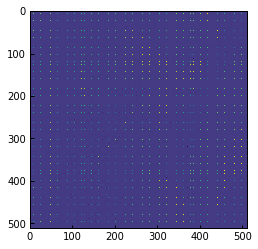

In [17]:
plt.imshow(Fk)
pd.DataFrame(Fk).to_csv("DMLCT_coef.csv",header=False,index=False)

# 係数の確保

In [18]:
Fk_Ori = np.copy(Fk)

# 逆変換

In [19]:
recover = np.zeros(IMG.img.shape)

## 横方向

### 残差

In [20]:
for k in range(1, n_bar - 2 + 1):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [21]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0]):
    for col in range(IMG.img.shape[1] // N):
        F = Fk[row, N * col : N * (col + 1)]
        F_L = get_F_L_k_horizontal(Fk, N, row, col)
        F_R = get_F_R_k_horizontal(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [22]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // N):
        F = Fk[row, N * col : N * col + N]
        data = scipy.fftpack.idct(F, norm="ortho")
        # Fkに代入した後、縦方向に対して処理
        Fk[row, N * col : N * col + N] = data

## 縦方向

### 残差

In [23]:
for k in range(1, n_bar - 2 + 1):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [24]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        # ビューなら直接いじっちゃう
        F = Fk[N * row : N * (row + 1), col]
        F_L = get_F_L_k_vertical(Fk, N, row, col)
        F_R = get_F_R_k_vertical(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [25]:
for row in range(Fk.shape[0] // N):
    for col in range(Fk.shape[1]):
        F = Fk[N * row : N * (row + 1), col]
        data = scipy.fftpack.idct(F, norm="ortho")
        # 復元画像
        recover[N * row : N * (row + 1), col] = data

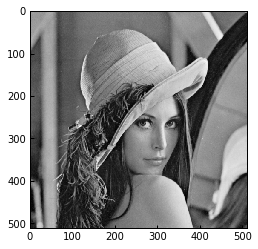

In [26]:
plt.imshow(recover.astype("u8"), cmap="gray")

もどった...！

# 量子化テーブル

In [27]:
Q50_Luminance = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

In [28]:
# Q=N0における量子化テーブルをスケーリング
Q = 12
if Q < 50:
    S = 5000 / Q
else:
    S = 200 - 2 * Q

S = np.floor(S)

Q_Luminance = np.zeros((N, N))
for row in range(N):
    for col in range(N):
        Q_Luminance[row, col] = np.floor((S * Q50_Luminance[row, col] + 50) / 100)

# 量子化

In [29]:
Fk = np.copy(Fk_Ori)
Q_Fk = np.zeros(Fk.shape)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1] // N):
        block = Fk[row * N : (row + 1) * N, col * N : (col + 1) * N]
        # 量子化
        block = np.round(block / Q_Luminance)
        # 逆量子化
        block = block * Q_Luminance
        Q_Fk[row * N : (row+1)*N, col * N : (col+1)*N] = block

In [30]:
Fk = np.copy(Q_Fk)
Q_recover = np.zeros(Q_Fk.shape)

## 横方向

### 残差

In [31]:
for k in range(1, n_bar - 2 + 1):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0]):
        for col in range(IMG.img.shape[1] // N):
            F = Fk[row, N * col : N * (col + 1)]
            F_L = get_F_L_k_horizontal(Fk, N, row, col)
            F_R = get_F_R_k_horizontal(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)
            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [32]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0]):
    for col in range(IMG.img.shape[1] // N):
        F = Fk[row, N * col : N * (col + 1)]
        F_L = get_F_L_k_horizontal(Fk, N, row, col)
        F_R = get_F_R_k_horizontal(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [33]:
for row in range(Fk.shape[0]):
    for col in range(Fk.shape[1] // N):
        F = Fk[row, N * col : N * col + N]
        data = scipy.fftpack.idct(F, norm="ortho")
        # Fkに代入した後、縦方向に対して処理
        Fk[row, N * col : N * col + N] = data

## 縦方向

### 残差

In [34]:
for k in range(1, n_bar - 2 + 1):
    dmlct = DMLCT(k+1, N)
    for row in range(IMG.img.shape[0] // N):
        for col in range(IMG.img.shape[1]):
            # ビューなら直接いじっちゃう
            F = Fk[N * row : N * (row + 1), col]
            F_L = get_F_L_k_vertical(Fk, N, row, col)
            F_R = get_F_R_k_vertical(Fk, N, row, col)

            U_k_n_bar = np.zeros(N)

            for kh in range((k + 1) - 2 + 1):
                U_k_n_bar += (
                    F_L[kh] * dmlct.W_L_k_kh[kh]
                    + F[kh] * dmlct.W_k_kh[kh]
                    + F_R[kh] * dmlct.W_R_k_kh[kh]
                )

            F[k] += U_k_n_bar[k]

In [35]:
dmlct = DMLCT(n_bar, N)
for row in range(IMG.img.shape[0] // N):
    for col in range(IMG.img.shape[1]):
        # ビューなら直接いじっちゃう
        F = Fk[N * row : N * (row + 1), col]
        F_L = get_F_L_k_vertical(Fk, N, row, col)
        F_R = get_F_R_k_vertical(Fk, N, row, col)

        U_k_n_bar = np.zeros(N)
        for kh in range(n_bar - 2 + 1):
            U_k_n_bar += (
                F_L[kh] * dmlct.W_L_k_kh[kh]
                + F[kh] * dmlct.W_k_kh[kh]
                + F_R[kh] * dmlct.W_R_k_kh[kh]
            )

        # n_bar = 4 なら 0,1,2は残す 3,4,5,6,7を書き換える
        F[n_bar - 2 + 1 :] += U_k_n_bar[n_bar - 2 + 1 :]

### IDCT

In [36]:
for row in range(Fk.shape[0] // N):
    for col in range(Fk.shape[1]):
        F = Fk[N * row : N * (row + 1), col]
        data = scipy.fftpack.idct(F, norm="ortho")
        # 復元画像
        Q_recover[N * row : N * (row + 1), col] = data

In [37]:
Q_recover = np.round(Q_recover)

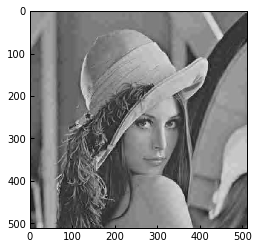

In [38]:
plt.imshow(Q_recover, cmap="gray")
plt.imsave("DMLCT_8x8_n"+str(n_bar)+ "_LENNA.png",Q_recover,cmap="gray")

# 情報量

In [39]:
qfk = pd.Series(Q_Fk.flatten())
pro = qfk.value_counts() / qfk.value_counts().sum()
pro.head()

 0.0     0.958031
-50.0    0.002403
 50.0    0.002193
-46.0    0.002060
 46.0    0.001736
dtype: float64

In [40]:
S = 0
for pi in pro:
    S -= pi * np.log2(pi)
S

0.4855469924790888

# PSNR

In [41]:
MSE = np.sum(np.sum(np.power((IMG.img - Q_recover),2)))/(Q_recover.shape[0] * Q_recover.shape[1])
PSNR = 10 * np.log10(255 * 255 / MSE)
PSNR

31.19052311829918

# MSSIM

In [42]:
MSSIM = ssim(IMG.img,Q_recover.astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)
MSSIM

0.842412299684649